## Deep Learning Group Project

Notebook done by:

- André Sousa 20240517
- Francisco Pontes 20211583
- Isabella Costa 20240685
- Jéssica Cristas 20240488
- Tiago Castilho 20240489

________


## Models

________


### Imports

In [143]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [144]:
src_path = "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/utils.py"

dst_path = "/content/utils.py"

!cp "{src_path}" "{dst_path}"


In [145]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report
from keras_cv.layers import RandomBrightness
from keras.metrics import F1Score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2, InceptionV3, DenseNet121
from tensorflow.keras.models import load_model


### HyperParameters and Constants

In [146]:
n_classes = 202
batch_size = 32
epochs = 5
input_shape = (224, 224, 3)
image_size = (299, 299)
optimizer = Adam(learning_rate=1e-4, name="optimizer")
loss = CategoricalCrossentropy(from_logits=False, name="categorical_crossentropy_loss")
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = layers.Rescaling(1./255)
width = 224
height = 224

In [147]:
metadata_path = "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/metadata.csv"

df = pd.read_csv(metadata_path)

In [148]:
os.makedirs("tfrecords", exist_ok=True)
paths = {
    "train": "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/tfrecords/train.tfrecord",
    "val": "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/tfrecords/val.tfrecord",
    "test": "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/tfrecords/test.tfrecord"
}

In [149]:
train_dir_path = "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/train"
val_dir_path = "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/val"
test_dir_path = "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/test"
metadata_path = "/content/drive/MyDrive/Deep Learning/Group17_DL_Project/metadata.csv"


### Importing Tensor Flow Records

In [150]:
# base_train_ds = image_dataset_from_directory(train_dir_path,
#     batch_size=batch_size,
#     verbose=False
# )

# base_val_ds = image_dataset_from_directory(
#     val_dir_path,
#     batch_size=batch_size,
#     verbose=False
# )

# base_test_ds = image_dataset_from_directory(
#     test_dir_path,
#     batch_size=batch_size,
#     verbose=False
# )

In [151]:
# # export tf records
# if not os.path.exists(paths["train"]):
#     write_tfrecord(base_train_ds, paths["train"], apply_augmentation=True)

# if not os.path.exists(paths["val"]):
#     write_tfrecord(base_val_ds, paths["val"])

# if not os.path.exists(paths["test"]):
#     write_tfrecord(base_test_ds, paths["test"])

In [152]:
def parse_record(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, width, height)
    return image, parsed['label']

In [153]:
def one_hot_label(x, y):
    return x, tf.one_hot(y, depth=n_classes)

In [154]:
train_ds = tf.data.TFRecordDataset(paths["train"])
train_ds = train_ds.map(parse_record, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(one_hot_label).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

val_ds = tf.data.TFRecordDataset(paths["val"])
val_ds = val_ds.map(parse_record, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label).batch(batch_size).prefetch(AUTOTUNE)

test_ds = tf.data.TFRecordDataset(paths["test"])
test_ds = test_ds.map(parse_record, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(one_hot_label).batch(batch_size).prefetch(AUTOTUNE)


________


### Class Weights

In [155]:
def calculate_class_weights(train_ds, n_classes):
    labels_list = []

    for _, labels in train_ds.unbatch():
        class_idx = tf.argmax(labels).numpy()
        labels_list.append(class_idx)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(n_classes),
        y=labels_list
    )

In [156]:
class_weights_dict = calculate_class_weights(train_ds=train_ds, n_classes=n_classes)

### CallBacks

In [157]:
callbacks = [
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=0,
            restore_best_weights=True,
            min_delta=0.1
        ),
        ModelCheckpoint(
            filepath=f'inceptionv3_fold_ft.keras',
            monitor='val_macro_f1',
            mode='max',
            save_best_only=True,
            save_weights_only=False
        )]

________


### Model Training

In [158]:
metrics=['accuracy', F1Score(average='macro',)]

raw_tfrecord_for_count = tf.data.TFRecordDataset(paths["train"])
total_train_images = sum(1 for _ in raw_tfrecord_for_count)
steps_per_epoch = total_train_images // batch_size

In [159]:
#optuna results with some finetunning
learning_rate =  0.00022631443241333675
dropout = 0.5
dense_units = 256
trainable_layers = 40

In [160]:
def build_model(base_model_fn):
    base_model = base_model_fn(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )
    return model
models_to_test = {
    'MobileNetV2': MobileNetV2,
    'InceptionV3': InceptionV3,
    'DenseNet121': DenseNet121,
}

In [161]:
for name, model_fn in models_to_test.items():
    print(f"\nTraining {name}...")

    model = build_model(model_fn)
    model.fit(train_ds, validation_data=val_ds, epochs=10)

test_acc, test_loss, test_f1 = model.evaluate(test_ds)



Training MobileNetV2...
Epoch 1/10
    240/Unknown 13s 25ms/step - accuracy: 0.0178 - f1_score: 0.0014 - loss: 5.4333

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.0178 - f1_score: 0.0014 - loss: 5.4329 - val_accuracy: 0.0274 - val_f1_score: 2.6364e-04 - val_loss: 5.2276
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0236 - f1_score: 0.0015 - loss: 5.2444 - val_accuracy: 0.0237 - val_f1_score: 2.4737e-04 - val_loss: 5.2446
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0234 - f1_score: 0.0014 - loss: 5.2489 - val_accuracy: 0.0286 - val_f1_score: 5.8316e-04 - val_loss: 5.2534
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0253 - f1_score: 0.0017 - loss: 5.2491 - val_accuracy: 0.0310 - val_f1_score: 9.2425e-04 - val_loss: 5.2286
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0264 - f1_score: 0.0017 - loss: 5.2308 - val_accuracy: 0.0274 - val_f1_score: 2.6364e-04 - val_loss: 5.1916
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0240 - f1_score: 0.0016 - loss: 5.2389 - val_accuracy: 0.0243 - val_

_______________________________________________________________________________

In [162]:
#must change due to input size
width = 299
height = 299
input_shape = (299, 299, 3)

In [163]:
def parse_record(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, width, height)
    return image, parsed['label']

In [164]:
def one_hot_label(x, y):
    return x, tf.one_hot(y, depth=n_classes)

In [165]:
train_ds = tf.data.TFRecordDataset(paths["train"])
train_ds = train_ds.map(parse_record, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(one_hot_label).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

val_ds = tf.data.TFRecordDataset(paths["val"])
val_ds = val_ds.map(parse_record, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label).batch(batch_size).prefetch(AUTOTUNE)

test_ds = tf.data.TFRecordDataset(paths["test"])
test_ds = test_ds.map(parse_record, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(one_hot_label).batch(batch_size).prefetch(AUTOTUNE)


In [166]:
def build_inceptionv3_model_ft(input_shape, n_classes, steps_per_epoch):
    base_model = tf.keras.applications.InceptionV3(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    for layer in base_model.layers[-trainable_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax', kernel_regularizer=l2(1e-3))(x)

    model = tf.keras.Model(inputs, outputs)

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=2.26e-4,
        decay_steps=100 * steps_per_epoch,
        alpha=1e-5
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            CategoricalAccuracy(name="accuracy"),
            F1Score(average='macro', name='macro_f1')
        ]
    )
    return model

In [167]:
model = build_inceptionv3_model_ft(input_shape, n_classes, steps_per_epoch)


hist_f1_test = model.fit(
    train_ds,
        validation_data=val_ds,
        epochs=50,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=2)

Epoch 1/50
240/240 - 43s - 178ms/step - accuracy: 0.1163 - loss: 5.3695 - macro_f1: 0.0258 - val_accuracy: 0.2772 - val_loss: 4.1980 - val_macro_f1: 0.0798
Epoch 2/50
240/240 - 10s - 40ms/step - accuracy: 0.2523 - loss: 4.2518 - macro_f1: 0.1026 - val_accuracy: 0.3891 - val_loss: 3.2657 - val_macro_f1: 0.1754
Epoch 3/50
240/240 - 10s - 40ms/step - accuracy: 0.3483 - loss: 3.4752 - macro_f1: 0.2085 - val_accuracy: 0.4784 - val_loss: 2.7872 - val_macro_f1: 0.3025
Epoch 4/50
240/240 - 10s - 40ms/step - accuracy: 0.4619 - loss: 2.8570 - macro_f1: 0.3294 - val_accuracy: 0.5191 - val_loss: 2.5320 - val_macro_f1: 0.3723
Epoch 5/50
240/240 - 10s - 40ms/step - accuracy: 0.5515 - loss: 2.3534 - macro_f1: 0.4399 - val_accuracy: 0.5550 - val_loss: 2.3590 - val_macro_f1: 0.4342
Epoch 6/50
240/240 - 10s - 40ms/step - accuracy: 0.6391 - loss: 1.9618 - macro_f1: 0.5381 - val_accuracy: 0.5757 - val_loss: 2.2281 - val_macro_f1: 0.4957
Epoch 7/50
240/240 - 9s - 39ms/step - accuracy: 0.7076 - loss: 1.6331

### Analyse classes with low F1 Score

In [168]:
def evaluate_f1_scores(val_ds, model):
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    report = classification_report(y_true, y_pred, output_dict=True)

    low_f1_classes = [int(cls) for cls, metrics in report.items() if cls.isdigit() and metrics["f1-score"] < 0.3]

    print(f"Classes with F1-Score < 0.3: {low_f1_classes}")

    return low_f1_classes, report

In [169]:
low_f1_classes, report = evaluate_f1_scores(val_ds, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Oversample of classes with low F1 Score

In [170]:
def data_aug():
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(factor=0.2),
    ])
    return data_augmentation

In [171]:
def serialize_example(image, label):
    image_encoded = tf.io.encode_jpeg(tf.cast(image * 255.0, tf.uint8)).numpy()
    feature = {
        'image': _bytes_feature(image_encoded),
        'label': _int64_feature(label.numpy())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()


In [172]:
data_augmentation = data_aug()

def write_adaptive_oversampled_tfrecord(dataset, path, target_classes, augment_times=2):
    with tf.io.TFRecordWriter(path) as writer:
        for img, lbl in dataset:
            # Ensure image is float32
            img = tf.cast(img, tf.float32)

            # Resize and normalize
            img = tf.image.resize_with_pad(img, 299, 299)
            img = normalization_layer(img)

            # Get label index (handle one-hot or int)
            lbl_idx = tf.argmax(lbl) if len(lbl.shape) > 0 else lbl

            # Serialize original image
            example = serialize_example(img, lbl_idx)
            writer.write(example)

            # Augment if label is in target_classes
            if lbl_idx in target_classes:
                for _ in range(augment_times):
                    aug_img = data_augmentation(img[None, ...], training=True)[0]
                    aug_img = normalization_layer(aug_img)
                    aug_example = serialize_example(aug_img, lbl_idx)
                    writer.write(aug_example)

In [173]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[int(value)]))

In [174]:
base_train_ds = image_dataset_from_directory(train_dir_path,
    batch_size=batch_size,
    verbose=False
)

In [175]:
adaptive_path = "tfrecords/train_adaptive.tfrecord"
write_adaptive_oversampled_tfrecord(
    base_train_ds.unbatch()
    .map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), tf.one_hot(y, depth=n_classes))),
    adaptive_path,
    target_classes=low_f1_classes,
    augment_times=2
)


In [176]:
#Load oversampling tfrecord for training
train_adaptive_ds = tf.data.TFRecordDataset(adaptive_path)
train_adaptive_ds = train_adaptive_ds.map(parse_record, num_parallel_calls=AUTOTUNE)
train_adaptive_ds = train_adaptive_ds.map(one_hot_label).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

### New Weights

In [177]:
class_weights_dict = calculate_class_weights(train_adaptive_ds, n_classes)

### New Callbacks

In [178]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=f'inceptionv3_oversampling.keras',
        monitor='val_macro_f1',
        mode='max',
        save_best_only=True,
        save_weights_only=False
    )
]

### Running second model with new oversampled classes

In [179]:
history_adaptive = model.fit(
    train_adaptive_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


340/340 - 18s - 54ms/step - accuracy: 0.4309 - loss: 3.0527 - macro_f1: 0.4391 - val_accuracy: 0.7070 - val_loss: 1.7490 - val_macro_f1: 0.6470
Epoch 2/50
340/340 - 12s - 37ms/step - accuracy: 0.5146 - loss: 2.5207 - macro_f1: 0.5400 - val_accuracy: 0.7702 - val_loss: 1.4844 - val_macro_f1: 0.7331
Epoch 3/50
340/340 - 12s - 36ms/step - accuracy: 0.5770 - loss: 2.2216 - macro_f1: 0.6219 - val_accuracy: 0.8024 - val_loss: 1.2983 - val_macro_f1: 0.7772
Epoch 4/50
340/340 - 12s - 36ms/step - accuracy: 0.6256 - loss: 2.0114 - macro_f1: 0.6842 - val_accuracy: 0.8413 - val_loss: 1.1950 - val_macro_f1: 0.8252
Epoch 5/50
340/340 - 12s - 37ms/step - accuracy: 0.6627 - loss: 1.8586 - macro_f1: 0.7252 - val_accuracy: 0.8541 - val_loss: 1.1321 - val_macro_f1: 0.8449
Epoch 6/50
340/340 - 14s - 40ms/step - accuracy: 0.6837 - loss: 1.7593 - macro_f1: 0.7576 - val_accuracy: 0.8638 - val_loss: 1.1067 - val_macro_f1: 0.8598
Epoch 7/50
340/340 - 11s - 33ms/step - accuracy: 0.7082 - loss: 1.6698 - macro_f1

### Evaluating and saving the model

In [180]:
final_model = load_model('inceptionv3_oversampling.keras')
test_results = final_model.evaluate(test_ds, verbose=2)
test_metrics = dict(zip(final_model.metrics_names, test_results))

print("\ntest_ds", test_metrics)

final_model.save(f'/content/drive/MyDrive/Deep Learning/final_final.keras')


52/52 - 14s - 271ms/step - accuracy: 0.8925 - loss: 0.7505 - macro_f1: 0.8813

test_ds {'loss': 0.7504631876945496, 'compile_metrics': 0.8924666047096252}


### Comparing the results of the model with and without oversampling

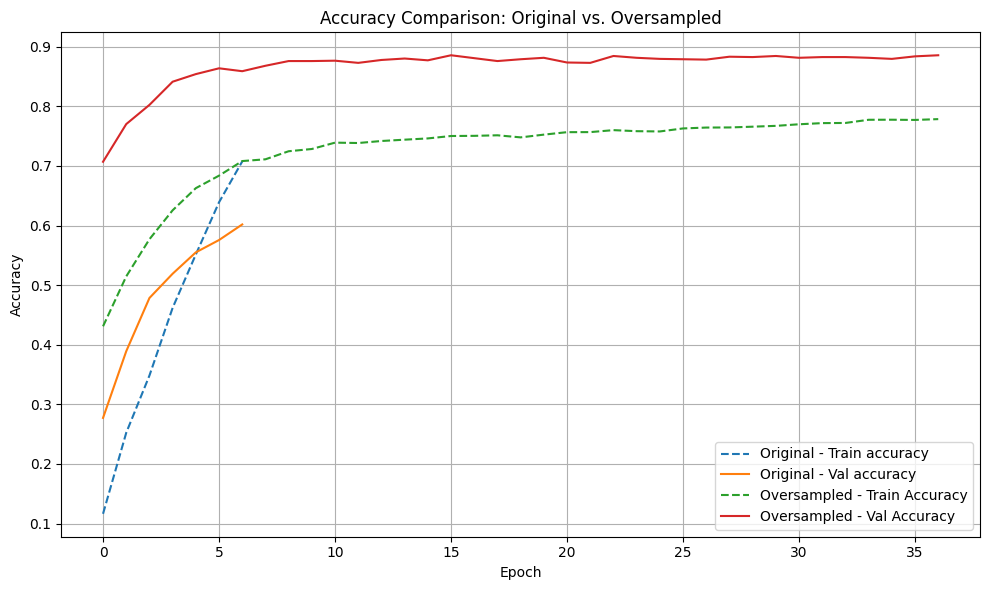

In [181]:
plt.figure(figsize=(10, 6))

plt.plot(hist_f1_test.history['accuracy'], label='Original - Train accuracy', linestyle='--')
plt.plot(hist_f1_test.history['val_accuracy'], label='Original - Val accuracy', linestyle='-')

plt.plot(history_adaptive.history['accuracy'], label='Oversampled - Train Accuracy', linestyle='--')
plt.plot(history_adaptive.history['val_accuracy'], label='Oversampled - Val Accuracy', linestyle='-')

plt.title("Accuracy Comparison: Original vs. Oversampled")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


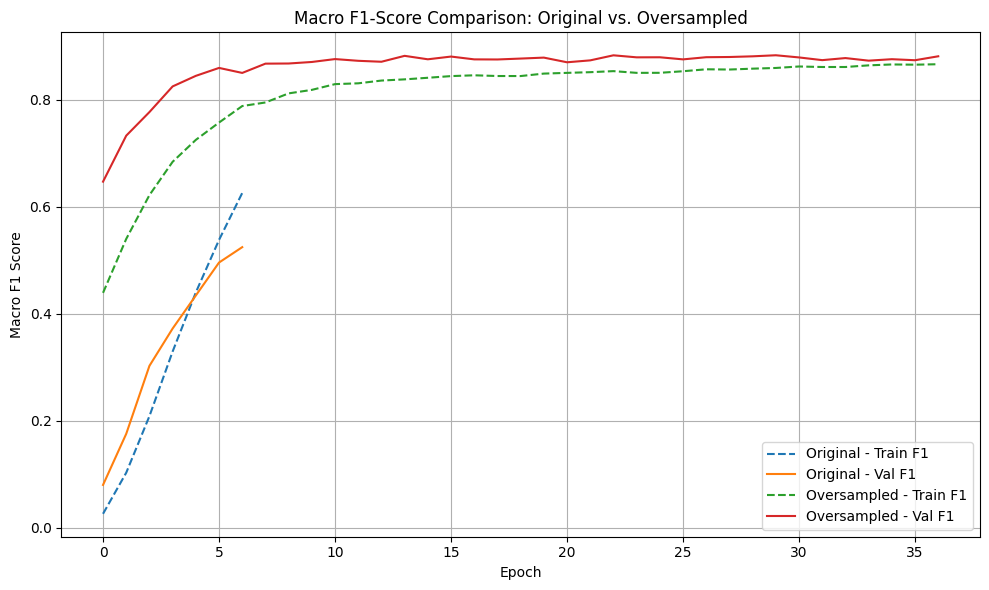

In [182]:
plt.figure(figsize=(10, 6))

plt.plot(hist_f1_test.history['macro_f1'], label='Original - Train F1', linestyle='--')
plt.plot(hist_f1_test.history['val_macro_f1'], label='Original - Val F1', linestyle='-')

plt.plot(history_adaptive.history['macro_f1'], label='Oversampled - Train F1', linestyle='--')
plt.plot(history_adaptive.history['val_macro_f1'], label='Oversampled - Val F1', linestyle='-')

plt.title("Macro F1-Score Comparison: Original vs. Oversampled")
plt.xlabel("Epoch")
plt.ylabel("Macro F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
